# Decision Tree

In this notebook we build a desicion tree based on Online Shoppers Purchasing Intention Dataset. We explore hyperparameters of the desicion tree using the ID3 decision tree learner from scikit-learn library. Learning algorithms that we looked at:

- Learning Algorithms
    - Gini 
    - Entropy

We also explore pre pruning methods to see if there is any improvement in accuracy and reliablitly of our desicion tree for both of above learning algorithms 

- Pre-pruning Methods
    - max_depth: maximum depth of decision tree: - [5,10,15]
    - min_sample_split: The minimum number of samples required to split an internal node - [2,3,4]
    - min_samples_leaf: The minimum number of samples required to be at a leaf no  - [1,2]

Finally, we investigate the nature of our imbalanced data on our best model with selecting equal number of samples from each class group to balance learning on these groups.

## The Dataset

- Class Names: indicating a revenue when True else False - ['False', 'True']
- Feature Names: ['ProductRelated_Duration', 'ProductRelatedAve', 'BounceRates', 'ExitRates', 'SpecialDay', 'Month', 'Region', 'VisitorType', 'Weekend']

## The Code

Our code is saved in the same folder with this report under descion_tree.py and data set is also at the same location called "online_shoppers_intention.csv". We created a set of definitions to help build our model

In [1]:
from Desicion_Tree import *

In [2]:
data_frame_os = read_data_return_frame("online_shoppers_intention.csv")

In [3]:
x, y, class_names, feature_names = preprocess_df(data_frame_os)

In [4]:
x_train, x_test, y_train, y_test, classifier = train_test_classifier(x, y, test_size = 0.25, criterion='gini')

* Creating prediction on training set using Gini Index without setting hyperparameters. This creates 100% accuracy and precision as expected

Train score 0.9998918568184276
Train Confusion matrix


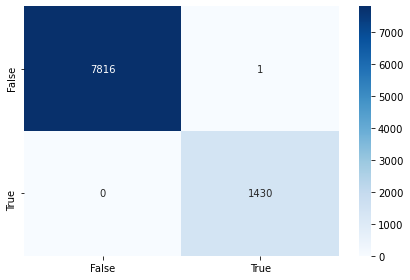

              False      True
precision  0.999872  1.000000
recall     1.000000  0.999301


In [5]:
y_pred_train = prediction(classifier, x_train)
accuracy_cm_report(y_train, y_pred_train, class_names = class_names, dom='Train')

* Creating prediction on validation set using Gini Index without setting hyperparameters. This creates 74% accuracy and 86% precision on False and 23% on True. This clearly shows that our model is overfitting on out trainin data. 

* It is important to nore that recall value is very low on True class which indicates the unbalanced nature of our data.

Validation score 0.7489458319818358
Validation Confusion matrix


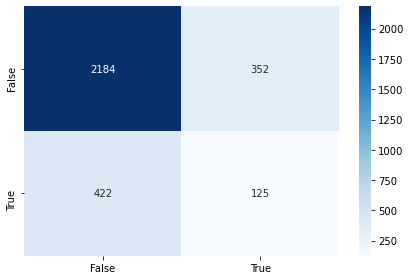

              False      True
precision  0.861199  0.228519
recall     0.838066  0.262055


In [6]:
y_pred_test = prediction(classifier, x_test)
accuracy_cm_report(y_test, y_pred_test, class_names = class_names, dom='Validation')

* Since we are aware that we are overfitting our data to our model, we can define hyperparameters to find best pruning model. For this we will use GridSearchCV adn extract best_estimator.

In [7]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

params = {'max_depth': [6,7,8,9,10],
         'min_samples_split': [2,3,4,5],
         'min_samples_leaf': [2,3,4,5]}

In [8]:
clf = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(x_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [6, 7, 8, 9, 10],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5]})

In [9]:
model = gcv.best_estimator_
model.fit(x_train,y_train)

print(f'Best Parameters are : {gcv.best_params_}')


Best Parameters are : {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 3}


* We now train our desicion tree with the best parameters we could find

Train score 0.8504379798853682
Train Confusion matrix


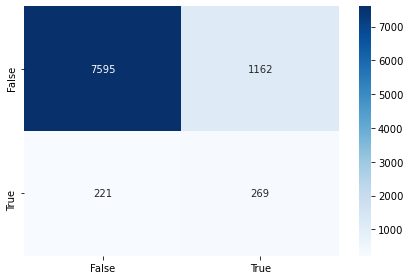

              False     True
precision  0.867306  0.54898
recall     0.971725  0.18798


In [10]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

accuracy_cm_report(y_train, y_pred_train, class_names = class_names, dom='Train')

While we decrease the accuracy in training set intentionally to avoid overfitting. Below is the effect that hyperparameters have on validation set

Validation score 0.8384690236782355
Validation Confusion matrix


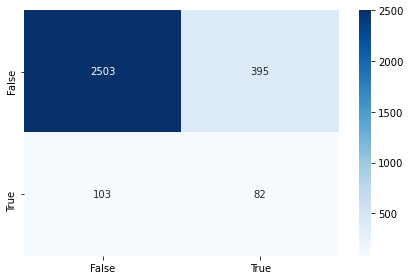

              False      True
precision  0.863699  0.443243
recall     0.960476  0.171908


In [11]:
accuracy_cm_report(y_test, y_pred_test, class_names = class_names, dom='Validation')

* With parameters used on validation set we are now reporting 83% on accuracy which is 9% more than previous version.
    * Where presicion stays almost the same for False class True class presicion increased by 22%
    * We observe an uplift on recall value on False class but 5% decrease on True class

# Avoiding Inbalanced Selection on Training Set

* First we find out what is the proportion of classes

In [23]:
x_true = x[y==1]
x_false = x[y==0]
y_true = y[y==1]
y_false = y[y==0]

print(f'True class has {len(y_true)} elements where False class has {len(y_false)} elements and the ratio is \
{len(y_false)/len(y_true)}')

True class has 1908 elements where False class has 10422 elements and the ratio is 5.462264150943396


StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set (sklearn.model_selection.StratifiedKFold — scikit-learn 0.24.1 documentation, n.d.).

In [20]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3)
for train, test in skf.split(x, y):
    print('train -  {}   |   test -  {}'.format(
        np.bincount(y[train]), np.bincount(y[test])))


train -  [6948 1272]   |   test -  [3474  636]
train -  [6948 1272]   |   test -  [3474  636]
train -  [6948 1272]   |   test -  [3474  636]


* It is common, in the case of class imbalances in particular, to use stratified n-fold cross-validation, which ensures that the proportion of positive to negative examples found in the original distribution is respected in all the folds (Haixiang et al., 2017).

In [25]:
for train_index, test_index in skf.split(x, y):
    x_train, x_test= x[train_index], x[test_index]
    y_train, y_test= y[train_index], y[test_index]
    
    model.fit(x_train,y_train)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    accuracy_cm_report(y_train, y_pred_train, class_names = class_names, dom='Train', brk = False)
    accuracy_cm_report(y_test, y_pred_test, class_names = class_names, dom='Test', brk = False)

Train score 0.8482968369829683
              False      True
precision  0.857878  0.549020
recall     0.983448  0.110063
Test score 0.845985401459854
              False      True
precision  0.845873  1.000000
recall     1.000000  0.004717
Train score 0.8482968369829683
              False      True
precision  0.848174  0.878788
recall     0.999424  0.022799
Test score 0.7401459854014598
              False      True
precision  0.842345  0.137584
recall     0.852044  0.128931
Train score 0.8635036496350365
              False      True
precision  0.876065  0.658228
recall     0.976684  0.245283
Test score 0.32116788321167883
              False      True
precision  0.871739  0.162382
recall     0.230858  0.814465


# References

sklearn.model_selection.StratifiedKFold — scikit-learn 0.24.1 documentation. (n.d.). 
    Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

Haixiang, G., Yijing, L., Shang, J., Mingyun, G., Yuanyue, H., & Bing, G. (2017). Learning from class-imbalanced data:
    Review of methods and applications. Expert Systems with Applications, 73, 220–239.


